### Simple Multi-AI agent

In [9]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import os
from dotenv import load_dotenv

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key 

langsmith_api_key = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
os.environ["LANGSMITH_TRACING"] = "true" 
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm

E0000 00:00:1760430332.787559   21007 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7f31d01286e0>, default_metadata=(), model_kwargs={})

In [10]:
class AgentState(MessagesState):
    next_agent:str #which agent should go next 

In [11]:
@tool
def search_web(query: str)-> str:
    """Search the web for information"""
    search = TavilySearch(max_results=2)
    results = search.invoke(query)
    return str(results)

@tool 
def write_summary(content: str) -> str:
    """Write a concise summary of the content"""
    summary = f"Summary: {content[:500]}..."  # Simple placeholder summary
    return summary

In [ ]:
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    messages = state["messages"]
    
    # Add system message for context (not wrapped in list)
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [ ]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    messages = state["messages"]
    
    # Add system message (not wrapped in list)
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [40]:
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state


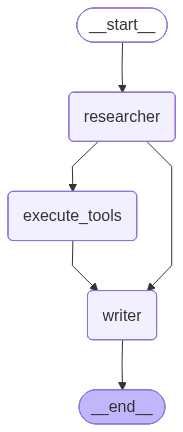

In [41]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("execute_tools", execute_tools)
workflow.add_node("writer", writer_agent)

workflow.set_entry_point("researcher")

workflow.add_edge("researcher", "execute_tools")
workflow.add_edge("execute_tools", "writer")
# Define flow
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [42]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 Unable to submit request because it must include at least one parts field, which describes the prompt input. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini

In [ ]:
response["messages"][-1].content